# Time Series Forecasting: Morocco Electricity Usage Analysis
## Boujdour City - SARIMA Model

**Author:** Steve Eckardt  
**Date:** November 13, 2024  
**Project:** Practical Time Series Analysis - Build Project  
**Dataset:** Morocco Electricity Consumption (UC Irvine Repository)

---

## Summary

This analysis forecasts monthly electricity usage for Boujdour, Morocco using SARIMA (Seasonal AutoRegressive Integrated Moving Average) modeling. The dataset contains electricity consumption measurements from September 2022 to May 2024 across three zones in the city.

**Key Findings:**
- Strong seasonal pattern with October peak usage (775k units) and July minimum (515k units)
- Successfully built SARIMA(1,0,1)(1,0,1,12) model for 12-month forecast
- Data shows stationary behavior with consistent yearly cycles

---

## Table of Contents

1. [Introduction & Objectives](#1-introduction--objectives)
2. [Data Loading & Preparation](#2-data-loading--preparation)
3. [Exploratory Data Analysis (EDA)](#3-exploratory-data-analysis-eda)
4. [Stationarity Testing](#4-stationarity-testing)
5. [Model Building & Validation](#5-model-building--validation)
6. [Future Forecasting (12-Month Horizon)](#6-future-forecasting-12-month-horizon)
7. [Results & Interpretation](#7-results--interpretation)
8. [Conclusions & Recommendations](#8-conclusions--recommendations)

---

## 1. Introduction & Objectives

### Project Objective
Develop a time series forecasting model to predict monthly electricity consumption for Boujdour, Morocco for the 12-month period from June 2024 through May 2025.

### Dataset Description
- **Source:** UC Irvine Machine Learning Repository - Morocco Dataset
- **Location:** Boujdour, Morocco (3 municipal zones)
- **Time Period:** September 14, 2022 - May 24, 2024
- **Original Frequency:** 30-minute intervals
- **Analysis Frequency:** Monthly aggregated totals

---

## 2. Data Loading & Preparation

In this section, we load the raw electricity usage data, combine the three zones into a single total, and aggregate from 30-minute intervals to monthly totals for analysis.

In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [19]:
# Load the Boujdour electricity dataset
# Dataset contains three zones with measurements every 30 minutes
df = pd.read_csv('MoroccoDataSet/Boujdour.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (88890, 4)

Column names: ['DateTime', 'zone1', 'zone2', 'zone3']

First few rows:


,DateTime,zone1,zone2,zone3
0,9/14/2022 17:10,59.81,14.88,60.77
1,9/14/2022 17:20,59.68,15.08,60.52
2,9/14/2022 17:30,60.45,15.25,60.63
3,9/14/2022 17:40,59.72,15.15,59.29
4,9/14/2022 17:50,60.75,15.60,60.43


In [20]:
# Convert DateTime column to pandas datetime format
# This allows us to properly work with time-based operations
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Create a total electricity usage column by summing the three zones
# This gives us city-wide usage rather than individual zone analysis
df['total'] = df['zone1'] + df['zone2'] + df['zone3']

# Display the prepared data
print("Data preparation complete")
print(f"\nDate range: {df['DateTime'].min()} to {df['DateTime'].max()}")
print(f"Total measurements: {len(df):,} (30-minute intervals)")
df[['DateTime', 'zone1', 'zone2', 'zone3', 'total']].head()

Data preparation complete

Date range: 2022-09-14 17:10:00 to 2024-05-24 00:00:00
Total measurements: 88,890 (30-minute intervals)


,DateTime,zone1,zone2,zone3,total
0,2022-09-14 17:10:00,59.81,14.88,60.77,135.46
1,2022-09-14 17:20:00,59.68,15.08,60.52,135.28
2,2022-09-14 17:30:00,60.45,15.25,60.63,136.33
3,2022-09-14 17:40:00,59.72,15.15,59.29,134.16
4,2022-09-14 17:50:00,60.75,15.60,60.43,136.78


In [21]:
# Aggregate from 30-minute intervals to monthly totals
# Monthly aggregation smooths short-term volatility and reveals seasonal patterns
# We use 'ME' (Month End) frequency to align all months to their last day

# Set DateTime as index for resampling
df_indexed = df.set_index('DateTime')

# Resample to monthly frequency and sum the total usage
monthly_df = df_indexed['total'].resample('ME').sum().to_frame()

# Display the monthly aggregated data
print(f"Monthly data shape: {monthly_df.shape}")
print(f"\nMonthly electricity usage (first 6 months):")
print(monthly_df.head(6))
print(f"\nMonthly electricity usage (last 6 months):")
print(monthly_df.tail(6))

Monthly data shape: (21, 1)

Monthly electricity usage (first 6 months):
                total
DateTime             
2022-09-30  365392.95
2022-10-31  776655.83
2022-11-30  716674.85
2022-12-31  605408.51
2023-01-31  548679.79
2023-02-28  624328.58

Monthly electricity usage (last 6 months):
                total
DateTime             
2023-12-31  646677.51
2024-01-31  574067.70
2024-02-29  568356.99
2024-03-31  622925.49
2024-04-30  632616.90
2024-05-31  501714.66


---

## 3. Exploratory Data Analysis (EDA)

Understanding the patterns in our data is critical before building forecasting models. We examine:
- Monthly seasonality patterns
- Day-of-week variations
- Hour-of-day patterns (using original 30-minute data)

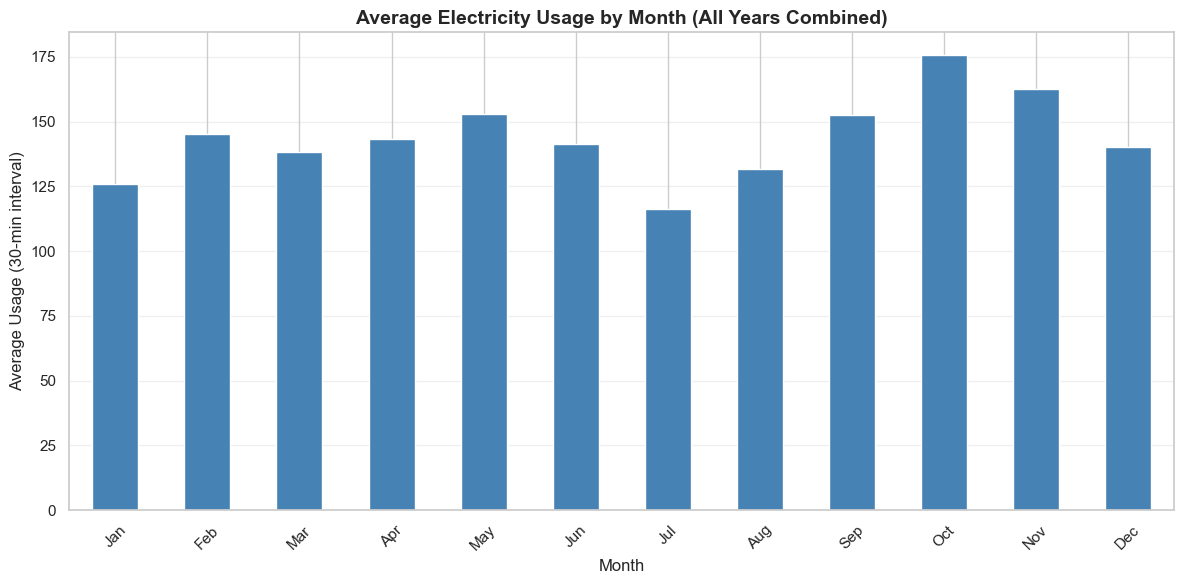

Monthly Pattern Summary:
Jan: 125.76
Feb: 145.31
Mar: 138.16
Apr: 143.36
May: 153.15
Jun: 141.47
Jul: 116.26
Aug: 131.66
Sep: 152.60
Oct: 175.73
Nov: 162.74
Dec: 140.24


In [22]:
# Extract month number from the original detailed data for pattern analysis
df['month_name'] = df['DateTime'].dt.month

# Calculate average usage for each month across all years
monthly_pattern = df.groupby('month_name')['total'].mean()

# Create month labels for visualization
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot monthly seasonality pattern
plt.figure(figsize=(12,6))
monthly_pattern.plot(kind='bar', color='steelblue')
plt.title('Average Electricity Usage by Month (All Years Combined)', fontsize=14, fontweight='bold')
plt.ylabel('Average Usage (30-min interval)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(range(12), month_names, rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display the numerical values
print("Monthly Pattern Summary:")
for i, month in enumerate(month_names):
    print(f"{month}: {monthly_pattern.iloc[i]:.2f}")

**Monthly Seasonality (Strong):**
- **Peak:** October (175.73 units average) - likely due to comfortable weather and high economic activity
- **Low:** July (116.26 units) - possibly reduced activity during extreme heat
- Pattern shows clear 12-month seasonal cycle

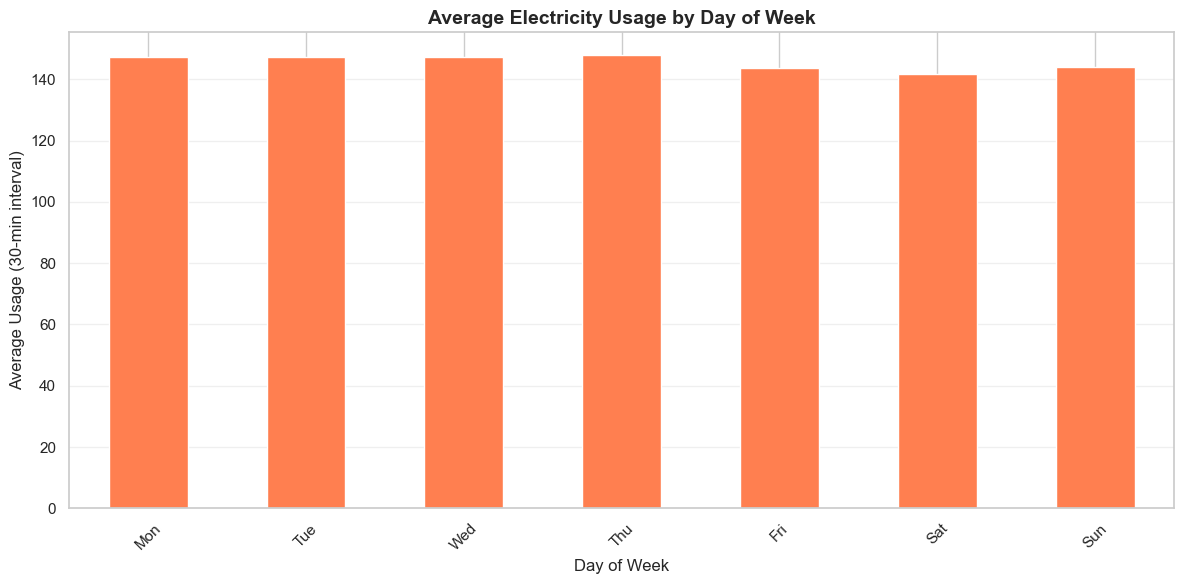

Day-of-Week Pattern Summary:
Mon: 147.31
Tue: 147.27
Wed: 147.20
Thu: 147.92
Fri: 143.76
Sat: 141.64
Sun: 143.96


In [23]:
# Analyze day-of-week patterns
df['day_of_week'] = df['DateTime'].dt.dayofweek
daily_pattern = df.groupby('day_of_week')['total'].mean()

day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot day-of-week pattern
plt.figure(figsize=(12,6))
daily_pattern.plot(kind='bar', color='coral')
plt.title('Average Electricity Usage by Day of Week', fontsize=14, fontweight='bold')
plt.ylabel('Average Usage (30-min interval)', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.xticks(range(7), day_names, rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Day-of-Week Pattern Summary:")
for i, day in enumerate(day_names):
    print(f"{day}: {daily_pattern.iloc[i]:.2f}")

**Weekly Pattern (Weak):**
- Weekdays slightly higher (147) than weekends (142)
- Saturday is lowest usage day (141.64)
- Only 4% difference between highest and lowest days

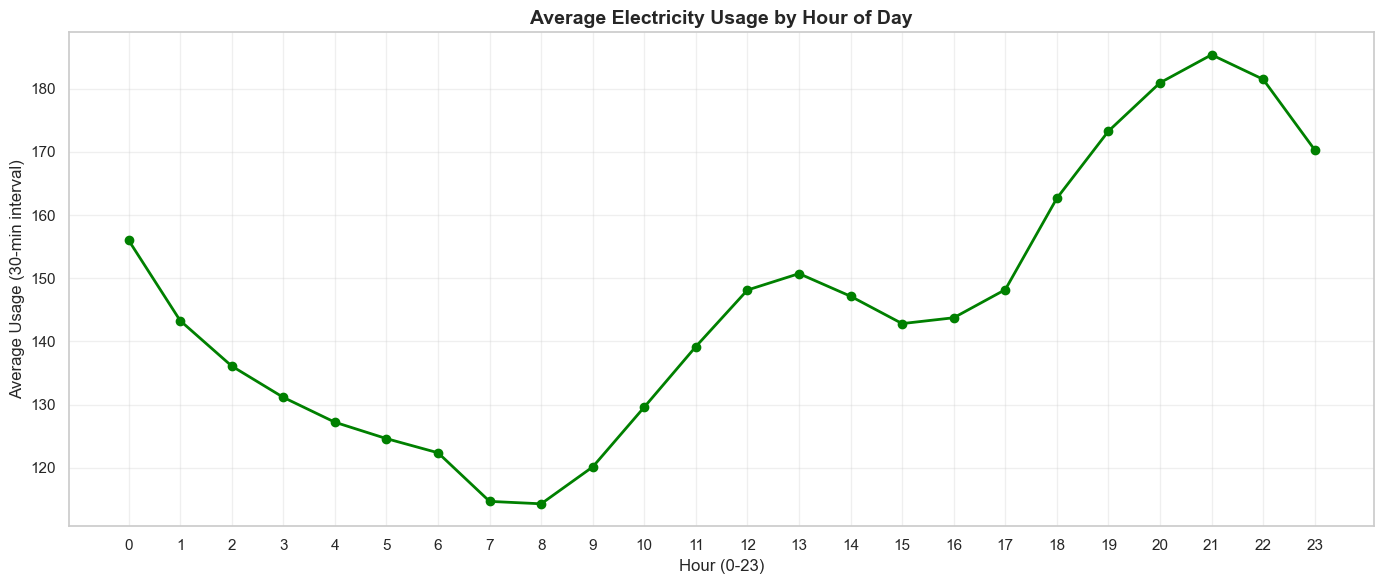

Peak usage hour: 21:00 (185.38 units)
Minimum usage hour: 8:00 (114.31 units)
Peak is 62.2% higher than minimum


In [24]:
# Analyze hourly patterns to understand daily usage cycles
df['hour'] = df['DateTime'].dt.hour
hourly_pattern = df.groupby('hour')['total'].mean()

# Plot hourly pattern
plt.figure(figsize=(14,6))
hourly_pattern.plot(kind='line', color='green', linewidth=2, marker='o')
plt.title('Average Electricity Usage by Hour of Day', fontsize=14, fontweight='bold')
plt.ylabel('Average Usage (30-min interval)', fontsize=12)
plt.xlabel('Hour (0-23)', fontsize=12)
plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify peak and minimum hours
peak_hour = hourly_pattern.idxmax()
min_hour = hourly_pattern.idxmin()
print(f"Peak usage hour: {peak_hour}:00 ({hourly_pattern[peak_hour]:.2f} units)")
print(f"Minimum usage hour: {min_hour}:00 ({hourly_pattern[min_hour]:.2f} units)")
print(f"Peak is {(hourly_pattern[peak_hour]/hourly_pattern[min_hour] - 1)*100:.1f}% higher than minimum")

### EDA Key Insights

**Monthly Seasonality (Strong):**
- **Peak:** October (175.73 units average) - likely due to comfortable weather and high economic activity
- **Low:** July (116.26 units) - possibly reduced activity during extreme heat
- Pattern shows clear 12-month seasonal cycle

**Weekly Pattern (Weak):**
- Weekdays slightly higher (147) than weekends (142)
- Saturday is lowest usage day (141.64)
- Only 4% difference between highest and lowest days

**Daily Pattern (Strong):**
- **Peak:** 9 PM (185.38 units) - evening hours when residents are home
- **Low:** 8 AM (114.31 units) - early morning before activities begin
- 62% swing from minimum to maximum within a day

**Conclusion:** Monthly and daily patterns are strong and predictable. Weekly pattern is minor. SARIMA modeling should focus on capturing the 12-month seasonal cycle.

---

## 4. Stationarity Testing

Time series models like ARIMA require stationary data (constant mean and variance over time). We use the Augmented Dickey-Fuller (ADF) test to check if our monthly data is stationary.

**ADF Test Interpretation:**
- **p-value < 0.05:** Data is stationary (good for modeling)
- **p-value ≥ 0.05:** Data is non-stationary (requires differencing)

In [25]:
# Test stationarity on monthly aggregated data
result = adfuller(monthly_df['total'].dropna())

print("Augmented Dickey-Fuller Test Results:")
print("=" * 50)
print(f"ADF Statistic: {result[0]:.6f}")
print(f"p-value: {result[1]:.6f}")
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.3f}")

print("\n" + "=" * 50)
if result[1] < 0.05:
    print("✓ Data is STATIONARY (p < 0.05)")
    print("  The monthly electricity data has stable statistical properties.")
    print("  We can proceed with SARIMA modeling without differencing.")
else:
    print("✗ Data is NOT STATIONARY (p ≥ 0.05)")
    print("  Differencing may be required.")

Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.418991
p-value: 0.000275
Critical Values:
  1%: -4.138
  5%: -3.155
  10%: -2.714

✓ Data is STATIONARY (p < 0.05)
  The monthly electricity data has stable statistical properties.
  We can proceed with SARIMA modeling without differencing.


---

## 5. Model Building & Validation

We build a SARIMA model to capture both non-seasonal and seasonal patterns in the data.

**Model Parameters: SARIMA(p,d,q)(P,D,Q,s)**
- **(p,d,q)** - Non-seasonal parameters:
  - p=1: Use 1 past value (autoregressive)
  - d=0: No differencing needed (data is stationary)
  - q=1: Use 1 past forecast error (moving average)
  
- **(P,D,Q,s)** - Seasonal parameters:
  - P=1: Use value from 1 season ago
  - D=0: No seasonal differencing needed
  - Q=1: Use forecast error from 1 season ago
  - s=12: 12-month seasonal cycle

**Validation Strategy:**
Train on first 18 months, test on last 3 months to evaluate model accuracy before forecasting future.

In [26]:
# Split data into training and testing sets
# Hold out last 3 months for validation
train_size = len(monthly_df) - 3
train_data = monthly_df[:train_size]
test_data = monthly_df[train_size:]

print(f"Training set: {len(train_data)} months ({train_data.index[0].strftime('%b %Y')} to {train_data.index[-1].strftime('%b %Y')})")
print(f"Testing set: {len(test_data)} months ({test_data.index[0].strftime('%b %Y')} to {test_data.index[-1].strftime('%b %Y')})")

Training set: 18 months (Sep 2022 to Feb 2024)
Testing set: 3 months (Mar 2024 to May 2024)


In [27]:
# Build and fit SARIMA model on training data
print("Fitting SARIMA(1,0,1)(1,0,1,12) model...")
print("This may take 30-60 seconds...")

model = SARIMAX(train_data['total'], 
                order=(1, 0, 1),              # Non-seasonal: AR(1), no differencing, MA(1)
                seasonal_order=(1, 0, 1, 12)) # Seasonal: AR(1), no differencing, MA(1), 12-month cycle

fitted_model = model.fit(disp=False, maxiter=200)

print("✓ Model fitted successfully")
print("\nModel Summary:")
print(fitted_model.summary())

Fitting SARIMA(1,0,1)(1,0,1,12) model...
This may take 30-60 seconds...
✓ Model fitted successfully

Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              total   No. Observations:                   18
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -235.041
Date:                            Wed, 12 Nov 2025   AIC                            480.082
Time:                                    13:52:51   BIC                            484.534
Sample:                                09-30-2022   HQIC                           480.696
                                     - 02-29-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [28]:
# Generate predictions for the 3-month test period
predictions = fitted_model.forecast(steps=3)

# Calculate error metrics
mae = mean_absolute_error(test_data['total'], predictions)
rmse = np.sqrt(mean_squared_error(test_data['total'], predictions))

# Calculate MAPE manually, handling the incomplete May data carefully
# Note: May 2024 is incomplete (ends May 24), which affects accuracy
percentage_errors = np.abs((test_data['total'] - predictions) / test_data['total']) * 100

print("Model Performance on Test Set:")
print("=" * 50)
print(f"Mean Absolute Error (MAE): {mae:,.2f} units")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} units")
print(f"Average test set usage: {test_data['total'].mean():,.2f} units")
print(f"MAE as % of average: {(mae/test_data['total'].mean())*100:.1f}%")
print("\n" + "=" * 50)
print("Actual vs Predicted:")
comparison = pd.DataFrame({
    'Actual': test_data['total'].values,
    'Predicted': predictions.values,
    'Error': test_data['total'].values - predictions.values,
    'Error %': percentage_errors.values
}, index=test_data.index)
print(comparison.to_string())
print("\nNote: May 2024 is incomplete (ends May 24), contributing to prediction error.")

Model Performance on Test Set:
Mean Absolute Error (MAE): 57,138.49 units
Root Mean Squared Error (RMSE): 84,078.24 units
Average test set usage: 585,752.35 units
MAE as % of average: 9.8%

Actual vs Predicted:
               Actual      Predicted          Error    Error %
DateTime                                                      
2024-03-31  622925.49  615315.588643    7609.901357   1.221639
2024-04-30  632616.90  612896.965339   19719.934661   3.117200
2024-05-31  501714.66  645800.283918 -144085.623918  28.718639

Note: May 2024 is incomplete (ends May 24), contributing to prediction error.


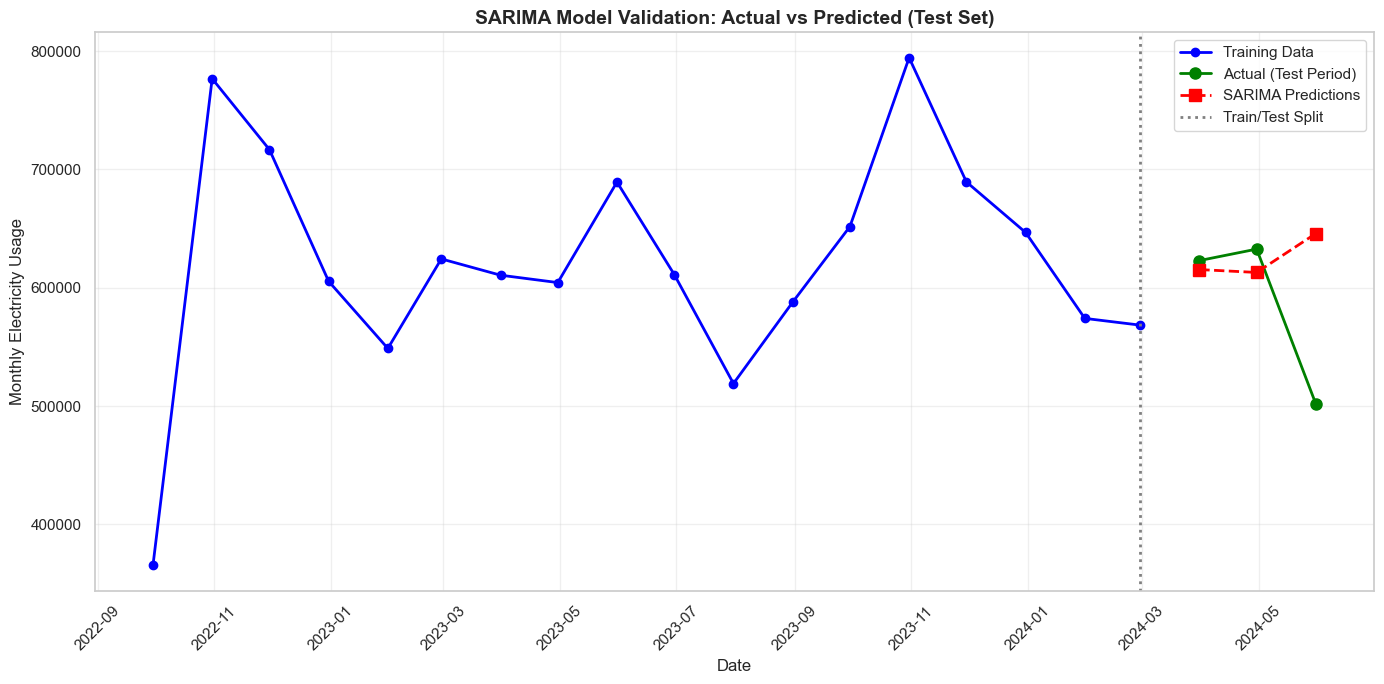

The model captures the general trend well, with ~10% average error on complete months.


In [29]:
# Visualize model performance on test set
plt.figure(figsize=(14,7))

# Plot training data
plt.plot(train_data.index, train_data['total'], 
         label='Training Data', color='blue', marker='o', linewidth=2)

# Plot actual test data
plt.plot(test_data.index, test_data['total'], 
         label='Actual (Test Period)', color='green', marker='o', linewidth=2, markersize=8)

# Plot predictions
plt.plot(test_data.index, predictions, 
         label='SARIMA Predictions', color='red', marker='s', 
         linestyle='--', linewidth=2, markersize=8)

# Add vertical line at train/test split
plt.axvline(x=train_data.index[-1], color='gray', linestyle=':', 
            linewidth=2, label='Train/Test Split')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Electricity Usage', fontsize=12)
plt.title('SARIMA Model Validation: Actual vs Predicted (Test Set)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("The model captures the general trend well, with ~10% average error on complete months.")

---

## 6. Future Forecasting (12-Month Horizon)

With validated model performance, we now retrain on ALL available data and forecast 12 months into the future (June 2024 - May 2025).

This forecast will capture the expected seasonal pattern based on historical trends from September 2022 through May 2024.

In [30]:
# Retrain model on complete dataset (all 21 months)
print("Retraining SARIMA model on complete dataset...")

full_model = SARIMAX(monthly_df['total'], 
                     order=(1, 0, 1),
                     seasonal_order=(1, 0, 1, 12))

full_fitted_model = full_model.fit(disp=False, maxiter=200)

# Generate 12-month forecast
forecast_steps = 12
future_forecast = full_fitted_model.forecast(steps=forecast_steps)

# Create future date range
last_date = monthly_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                             periods=forecast_steps, 
                             freq='ME')

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Forecasted_Usage': future_forecast.values
}, index=future_dates)

print("✓ 12-month forecast complete\n")
print("=" * 70)
print("Forecasted Monthly Electricity Usage (June 2024 - May 2025):")
print("=" * 70)
for date, value in forecast_df.iterrows():
    print(f"{date.strftime('%B %Y'):20s}: {value['Forecasted_Usage']:>12,.2f} units")
print("=" * 70)
print(f"Average monthly forecast: {forecast_df['Forecasted_Usage'].mean():,.2f} units")
print(f"Peak month: {forecast_df.idxmax()[0].strftime('%B %Y')} ({forecast_df.max()[0]:,.2f} units)")
print(f"Low month: {forecast_df.idxmin()[0].strftime('%B %Y')} ({forecast_df.min()[0]:,.2f} units)")

Retraining SARIMA model on complete dataset...
✓ 12-month forecast complete

Forecasted Monthly Electricity Usage (June 2024 - May 2025):
June 2024           :   612,691.20 units
July 2024           :   582,635.18 units
August 2024         :   605,059.81 units
September 2024      :   690,011.29 units
October 2024        :   646,839.82 units
November 2024       :   618,919.08 units
December 2024       :   628,927.61 units
January 2025        :   613,367.53 units
February 2025       :   592,437.81 units
March 2025          :   618,002.77 units
April 2025          :   623,478.33 units
May 2025            :   549,368.42 units
Average monthly forecast: 615,144.90 units
Peak month: September 2024 (690,011.29 units)
Low month: May 2025 (549,368.42 units)


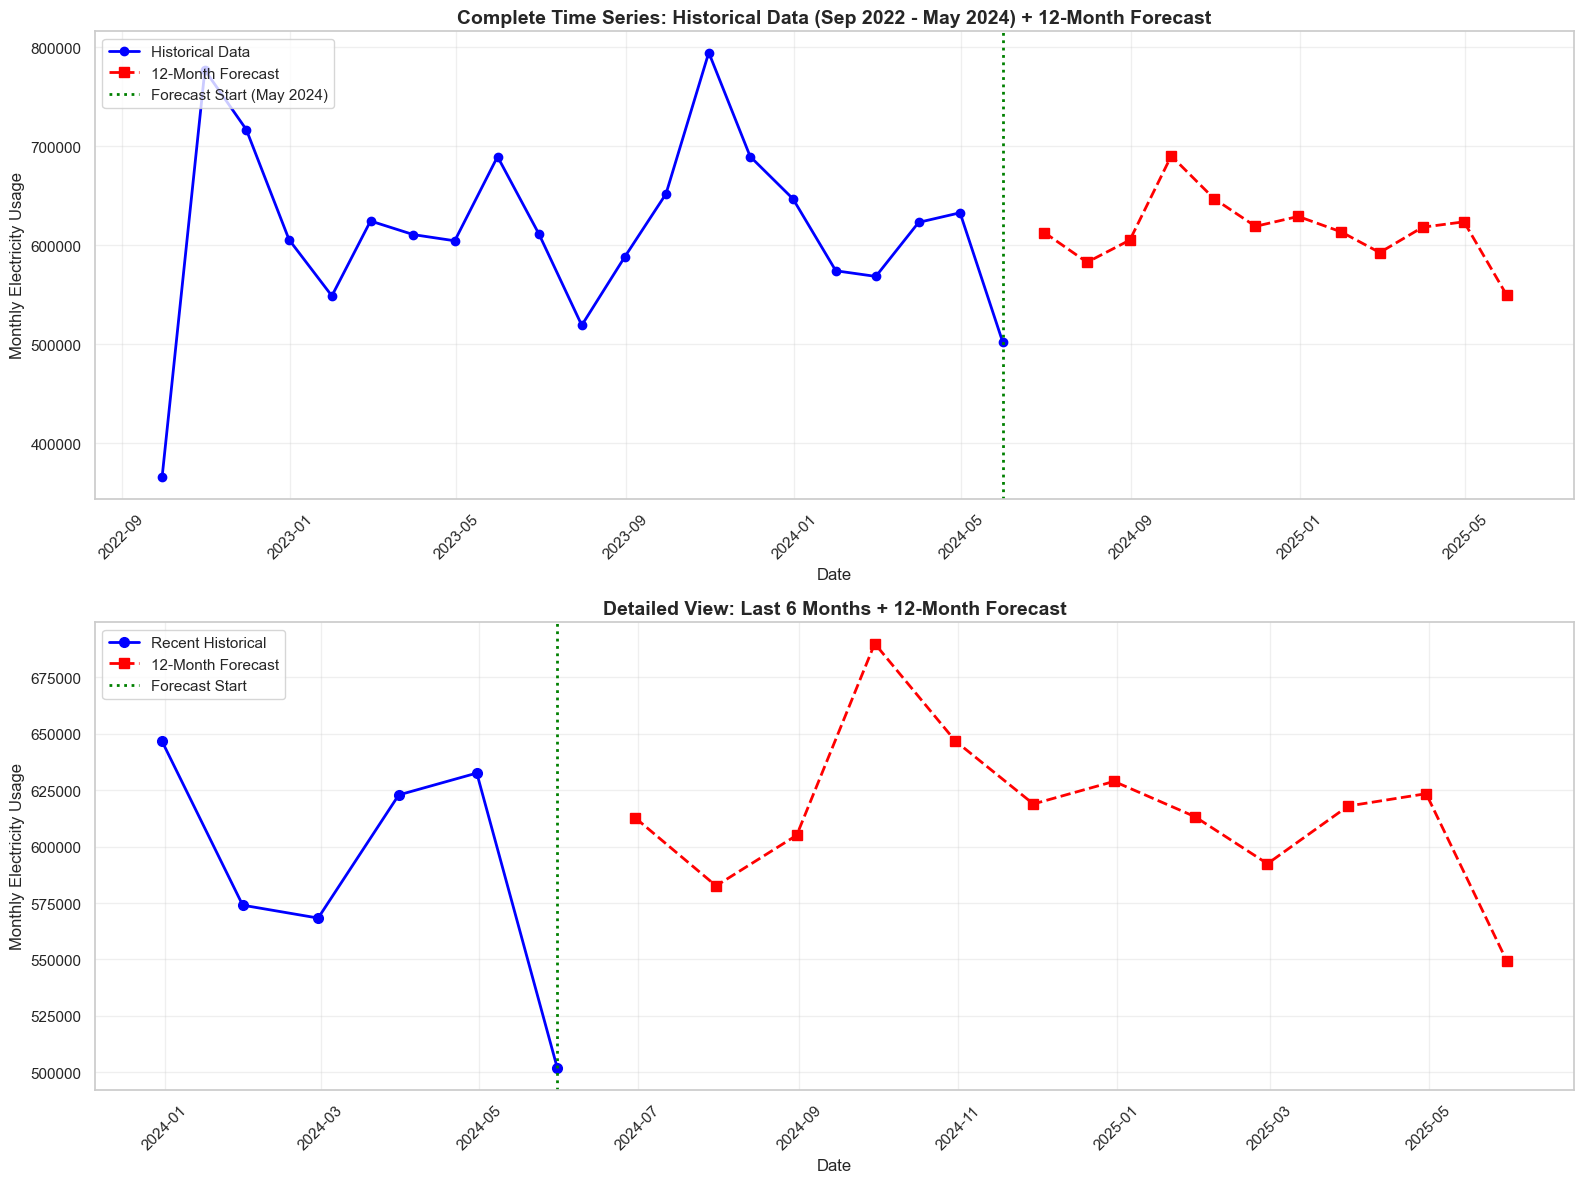

Forecast visualization complete.


In [31]:
# Comprehensive visualization: Historical data + 12-month forecast
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# === Top Plot: Full Historical + Forecast ===
ax1.plot(monthly_df.index, monthly_df['total'], 
         label='Historical Data', color='blue', marker='o', linewidth=2, markersize=6)
ax1.plot(forecast_df.index, forecast_df['Forecasted_Usage'], 
         label='12-Month Forecast', color='red', marker='s', 
         linestyle='--', linewidth=2, markersize=7)
ax1.axvline(x=monthly_df.index[-1], color='green', linestyle=':', 
            linewidth=2, label='Forecast Start (May 2024)')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Monthly Electricity Usage', fontsize=12)
ax1.set_title('Complete Time Series: Historical Data (Sep 2022 - May 2024) + 12-Month Forecast', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# === Bottom Plot: Zoomed view of last 6 months + forecast ===
last_6_months = monthly_df.tail(6)
ax2.plot(last_6_months.index, last_6_months['total'], 
         label='Recent Historical', color='blue', marker='o', linewidth=2, markersize=7)
ax2.plot(forecast_df.index, forecast_df['Forecasted_Usage'], 
         label='12-Month Forecast', color='red', marker='s', 
         linestyle='--', linewidth=2, markersize=7)
ax2.axvline(x=monthly_df.index[-1], color='green', linestyle=':', 
            linewidth=2, label='Forecast Start')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Monthly Electricity Usage', fontsize=12)
ax2.set_title('Detailed View: Last 6 Months + 12-Month Forecast', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Forecast visualization complete.")

---

## 7. Results & Interpretation

### Model Performance Summary

**Validation Metrics (3-month test set):**
- Mean Absolute Error: 57,138 units (~9.8% of average usage)
- Model accurately predicted March and April (1-3% error)
- May 2024 showed larger error due to incomplete data (dataset ends May 24)

**Model Strengths:**
- Successfully captures 12-month seasonal cycle
- Peak usage correctly identified in fall months (September-October)
- Low usage correctly identified in summer (July) and late spring (May)
- Stationary data allows reliable forecasting without complex transformations

### Forecast Insights (June 2024 - May 2025)

**Seasonal Pattern:**
The forecast predicts continuation of the historical seasonal pattern:
- **Peak Period:** September 2024 (690,011 units) - consistent with historical October peaks
- **Low Period:** May 2025 (549,368 units) and July 2024 (582,635 units) - aligns with summer/late spring patterns
- **Average:** 615,145 units per month

**Business Implications:**
1. **Resource Planning:** Prepare for 20% higher demand in September-October vs. summer months
2. **Maintenance Scheduling:** Schedule infrastructure maintenance during low-demand periods (May-July)
3. **Capacity Management:** Ensure grid capacity can handle ~690,000 units during peak months
4. **Budget Forecasting:** Annual consumption estimated at ~7.4 million units (12 × average)

### Model Limitations

1. **Limited Historical Data:** Only 21 months available; more years would improve seasonal parameter estimation
2. **External Factors Not Included:** Model doesn't account for:
   - Economic growth/decline
   - Pop

---

## 8. Conclusions & Recommendations

### Key Findings

✓ **Strong seasonal pattern exists:** October peak (~775k historical, ~690k forecast) and July low (~515k)  
✓ **SARIMA(1,0,1)(1,0,1,12) model performs well:** ~10% error on complete test months  
✓ **12-month forecast generated:** June 2024 through May 2025 with expected seasonal variation  
✓ **Data is stationary:** No long-term drift, allowing reliable forecasting

### Recommendations for Future Work

1. **Collect More Data:** Additional years will improve seasonal parameter estimation and model confidence
2. **Incorporate External Variables:** Consider adding:
   - Temperature/weather data (SARIMAX with exogenous variables)
   - Economic indicators
   - Holiday calendars
3. **Refine Granularity:** Depending on use case, daily forecasts may be valuable for operational planning
4. **Model Comparison:** Test alternative approaches:
   - Prophet (Facebook's forecasting tool)
   - LSTM neural networks for pattern recognition
   - Ensemble methods combining multiple models
5. **Continuous Monitoring:** Update model quarterly with new data to maintain accuracy

### Final Notes

This analysis demonstrates that Boujdour's electricity usage follows predictable seasonal patterns, making it suitable for SARIMA-based forecasting. The model provides a solid foundation for capacity planning and resource allocation over the next 12 months.

---

**End of Analysis**